<a href="https://colab.research.google.com/github/topchaebol/dacon/blob/master/%EC%83%9D%EC%B2%B4%EA%B4%91%ED%95%99_baseline_0521_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings(action='ignore')

In [22]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')
train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,1.098559e-17,8.907142e-19,NaN,0.000000e+00,NaN,0.000000e+00,5.901745e-18,NaN,1.176812e-18,NaN,5.557492e-17,1.046498e-16,NaN,7.236748e-17,4.021610e-17,2.397489e-17,1.870153e-17,1.808920e-17,NaN,0.000000e+00,2.626216e-18,NaN,3.527371e-18,NaN,6.455564e-19,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,1.151021e-10,4.318673e-10,2.753933e-10,0.000000e+00,8.138830e-10,6.522110e-10,NaN,2.732232e-10,NaN,7.663267e-11,NaN,1.389496e-10,1.472282e-09,1.450463e-09,1.225321e-09,2.647633e-09,NaN,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,0.000000e+00,NaN,NaN,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,3.349335e-19,NaN,0.000000e+00,2.630961e-18,NaN,0.000000e+00,9.912979e-18,1.112747e-17,NaN,NaN,NaN,1.260239e-19,NaN,0.000000e+00,3.876159e-18,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,NaN,1.583839e-10,NaN,1.678049e-10,2.814419e-10,4.429321e-10,1.319956e-09,2.269806e-09,2.679164e-09,2.538200e-09,2.046841e-09,1.516820e-09,1.328007e-09,1.061359e-09,8.634016e-10,5.804951e-10,3.615067e-10,NaN,1.274876e-10,6.118947e-11,NaN,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.01455,0.98861,0.98300,1.00616,0.99045,1.01321,1.01559,1.01072,0.99439,0.98597,0.99889,1.01412,4.784751e-14,NaN,0.000000e+00,1.153089e-13,0.000000e+00,0.000000e+00,1.056991e-13,0.000000e+00,0.000000e+00,2.666663e-14,1.493071e-14,NaN,0.000000e+00,1.200730e-13,2.648249e-13,NaN,4.392331e-13,2.831191e-13,4.557059e-13,1.326038e-13,1.864796e-13,1.419359e-13,1.765559e-13,1.593789e-13,NaN,0.000000e+00,NaN,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN,11.9

In [23]:
test.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,10000,15,0.15406,0.23275,0.30977,0.42949,0.51264,0.62558,0.74340,0.85418,0.90815,0.95973,0.98963,1.00633,0.93637,0.90501,0.80721,0.67517,0.56850,0.47049,0.37681,0.28318,0.20309,0.14741,0.10475,0.05867,0.06330,0.02841,0.01290,0.00132,0.00000,0.00000,0.01904,0.00000,0.01952,0.00000,0.01285,0.000000e+00,NaN,7.028318e-15,NaN,NaN,2.191340e-14,2.204989e-14,0.000000e+00,0.000000e+00,1.306867e-15,NaN,7.064663e-14,9.958556e-14,2.511703e-13,8.145713e-13,NaN,NaN,7.970892e-13,NaN,2.803227e-13,1.466433e-13,NaN,5.927522e-14,2.185519e-14,NaN,0.000000e+00,0.000000e+00,1.432248e-14,0.000000e+00,0.000000e+00,6.332117e-15,1.429966e-14,0.000000e+00,NaN,7.320236e-14
1,10001,15,0.48552,0.56939,0.67575,0.79089,0.85114,0.92581,0.98071,0.98177,0.98678,0.95641,0.87884,0.80476,0.71898,0.60703,0.50844,0.43139,0.34349,0.26715,0.17880,0.15375,0.09830,0.06955,0.03164,0.03791,0.03539,0.01144,0.00703,0.00096,0.01406,0.00000,0.00223,0.01188,0.00000,0.00910,0.00201,NaN,3.744801e-13,1.190392e-14,9.131521e-13,1.796724e-14,1.081485e-14,0.000000e+00,0.000000e+00,NaN,1.810959e-14,8.088957e-13,1.425479e-12,NaN,1.757695e-12,1.816649e-12,4.615024e-12,3.979741e-12,NaN,NaN,1.089426e-12,NaN,4.849117e-13,3.003396e-13,3.783172e-14,3.432298e-14,1.036013e-13,NaN,2.830975e-14,1.114337e-13,4.825731e-14,NaN,2.282485e-14,7.348414e-14,1.259055e-13,2.349874e-13
2,10002,10,0.46883,0.56085,0.62442,0.73172,0.81724,0.91517,0.94801,0.99108,1.01261,0.96075,0.88151,0.80859,0.73041,0.62614,0.52916,0.46809,0.40735,0.35620,0.32311,0.27406,0.23611,0.19970,0.18395,0.17000,0.14073,0.13508,0.14524,0.10918,0.10280,0.10387,0.09468,0.06623,0.08721,0.06559,0.06880,1.732202e-12,1.827363e-11,1.332869e-11,2.641682e-12,3.498661e-12,1.466659e-11,2.981251e-11,2.764069e-11,0.000000e+00,3.423157e-12,4.370910e-11,1.748554e-11,3.404800e-11,8.673897e-11,1.875337e-10,2.337955e-10,2.074666e-10,1.742070e-10,NaN,9.815230e-11,NaN,6.323332e-11,5.504236e-11,3.523197e-11,1.264857e-11,NaN,NaN,NaN,NaN,1.569208e-11,6.242378e-12,NaN,1.219010e-11,NaN,NaN
3,10003,10,0.06905,0.07517,0.10226,0.14905,0.16182,0.19659,0.26085,0.36753,0.51432,0.70530,0.92052,1.00194,0.92491,0.70450,0.52336,0.37686,0.26057,0.22032,0.14476,0.11934,0.09141,0.09077,0.08446,0.07500,0.06403,0.04793,0.03783,0.04006,0.02746,0.04642,0.00630,0.01501,0.01071,0.03310,0.01281,0.000000e+00,NaN,0.000000e+00,2.713471e-12,6.567726e-12,2.069053e-12,3.467277e-12,0.000000e+00,1.275280e-11,NaN,1.257803e-11,1.179720e-11,1.207228e-10,2.049794e-10,3.930583e-10,4.045076e-10,2.890125e-10,NaN,NaN,9.696636e-11,7.976577e-11,6.720191e-11,5.054397e-11,3.088529e-11,7.378972e-12,1.651177e-11,7.282747e-12,5.010879e-12,NaN,1.571023e-11,0.000000e+00,0.000000e+00,3.304247e-12,4.106134e-11,NaN
4,10004,25,0.00253,0.00757,0.01649,0.00128,0.00000,0.00000,0.00105,0.01975,0.00000,0.00526,0.00000,0.00111,0.00000,0.00000,0.00651,0.00000,0.00544,0.04805,0.05783,0.09923,0.17500,0.26861,0.33419,0.47074,0.58215,0.72828,0.83838,0.92615,0.96783,0.99902,1.00555,0.95138,0.91243,0.85656,0.76263,0.000000e+00,4.030214e-17,NaN,2.500016e-17,0.000000e+00,0.000000e+00,0.000000e+00,3.969590e-17,1.461565e-18,NaN,9.746350e-18,1.664548e-17,1.931133e-17,2.261459e-17,2.263433e-18,2.424745e-17,0.000000e+00,1.911587e-17,0.0,1.471418e-17,1.964881e-17,NaN,5.723552e-17,4.577178e-17,4.128159e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.732057e-17,4.110605e-17,0.000000e+00,0.000000e+00,1.910775e-16,2.215673e-15


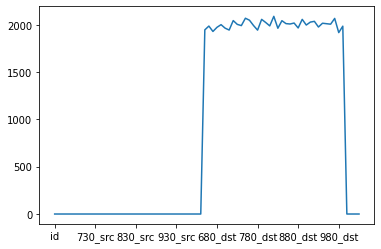

In [24]:
train.isna().sum().plot()

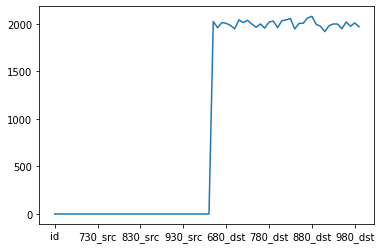

In [25]:
test.isna().sum().plot()

In [0]:
test = test.fillna(train.mean())
train = train.fillna(train.mean())

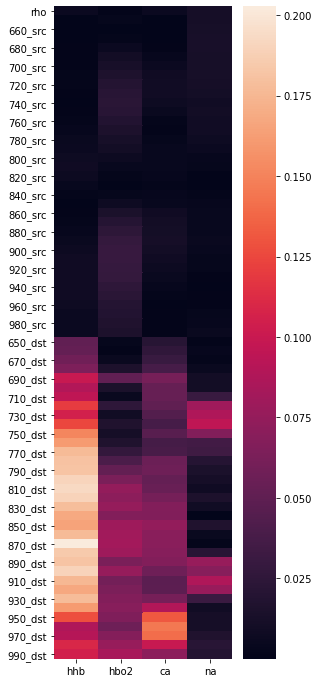

In [27]:
plt.figure(figsize=(4,12))
sns.heatmap(train.corr().loc['rho':'990_dst','hhb':].abs())

In [28]:
x_train = train.loc[:,'650_dst':'990_dst']
y_train = train.loc[:,'hhb':'na']
x_train.shape, y_train.shape

((10000, 35), (10000, 4))

In [0]:
def train_model(x_data, y_data, k=5):
    models = []
    k_fold = KFold(n_splits=k, shuffle=True, random_state=123)

    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]

        d_train = xgb.DMatrix(data = x_train, label = y_train)
        d_val = xgb.DMatrix(data = x_val, label = y_val)

        wlist = [(d_train, 'train'), (d_val, 'eval')]

        params = {
            'eval_metric' : 'mae',
            'seed' : 777
        }

        model = xgb.train(params =params, dtrain=d_train, num_boost_round=500, verbose_eval=500, evals = wlist)
        models.append(model)

    return models

In [37]:
models = {}
for label in y_train.columns:
  print('train column:', label)
  models[label] = train_model(x_train, y_train[label])

train column: hhb
[0]	train-mae:5.32221	eval-mae:5.30458
[499]	train-mae:0.041922	eval-mae:1.86661
[0]	train-mae:5.32727	eval-mae:5.26705
[499]	train-mae:0.037516	eval-mae:1.85421
[0]	train-mae:5.32278	eval-mae:5.3072
[499]	train-mae:0.038589	eval-mae:1.92132
[0]	train-mae:5.31354	eval-mae:5.35914
[499]	train-mae:0.037898	eval-mae:1.88682
[0]	train-mae:5.31246	eval-mae:5.37954
[499]	train-mae:0.036813	eval-mae:1.85131
train column: hbo2
[0]	train-mae:2.46025	eval-mae:2.474
[499]	train-mae:0.018869	eval-mae:0.79524
[0]	train-mae:2.45931	eval-mae:2.47805
[499]	train-mae:0.018604	eval-mae:0.802734
[0]	train-mae:2.46738	eval-mae:2.42502
[499]	train-mae:0.019036	eval-mae:0.820432
[0]	train-mae:2.45922	eval-mae:2.47788
[499]	train-mae:0.020112	eval-mae:0.811115
[0]	train-mae:2.46275	eval-mae:2.45569
[499]	train-mae:0.019803	eval-mae:0.808114
train column: ca
[0]	train-mae:5.99717	eval-mae:6.09502
[499]	train-mae:0.047618	eval-mae:2.34335
[0]	train-mae:6.0047	eval-mae:6.02908
[499]	train-mae:

In [0]:
for col in models:
  preds = []
  for model in models[col]:
    preds.append(model.predict(xgb.DMatrix(test.loc[:, '650_dst':])))
  pred = np.mean(preds, axis = 0)

  submission[col] = pred
  

In [39]:
submission.head()

,id,hhb,hbo2,ca,na
0,10000,7.672807,3.994872,9.086050,3.092227
1,10001,5.597369,4.154807,8.262137,2.093462
2,10002,10.586995,4.555421,11.061234,3.867779
3,10003,8.480302,4.129624,10.989163,3.177399
4,10004,8.713501,2.920488,8.031573,4.157152


In [0]:
submission.to_csv('Dacon_baseline.csv', index = False)